<h1 style="text-align:center;text-decoration: underline">Astronomy 350 Final Project</h1>

Prof. Quimby <br>
Spring 2025 <br>
**Steps 1-4 Due May 7 at 5pm** <br>
**Steps 5-7 (including the written report) due May 13 at 5pm**

**Student Name:**

## Background

The temperature and luminosity of a star for the majority of its core hydrogen-burning lifetime is largely dictated by a single parameter: the mass of the star at birth. The color and luminosity of most stars are highly correlated and populate only a limited region in the parameter space of color and magnitude. Theoretical models have be developed to explain how a cloud of gas collapses and fragments into individual stars that go on to populate this main sequence, and how these stars will change in brightness and color as they age. These can in turn be used to measure the ages of real star clusters using the observed magnitudes of the stars and the colors and luminosities predicted by the models. 

## Assignment

Use Gaia and MLO 1.0-m data to measure the distance, age and E(B-V) color excess to one of the following star clusters using stellar isochrones and $\chi^2$ fitting techniques.

| Name    | R.A.     |  Dec.     |
| ---     | ---      | ---       |
| NGC1912 | 05 28 40 | +35 50 54 |
| NGC1960 | 05 36 18 | +34 08 24 |
| NGC2099 | 05 52 18 | +32 33 12 |
| NGC2215 | 06 20 49 | -07 17 00 |
| NGC2301 | 06 51 45 | +00 27 36 |
| NGC2323 | 07 02 42 | -08 23 00 |
| NGC2343 | 07 08 06 | -10 37 00 |
| NGC2353 | 07 14 30 | -10 16 00 |
| NGC2437 | 07 41 46 | -14 48 36 |


## Resources:
Coordinate matching tutorial (from Lecture 6)
- [notebook](../tutorials/coordinate.matching.ipynb) (you may need to change the path for this link to work)
/ [video](https://youtu.be/iE5fhebaxSo) (28 min)

HR Diagram:
- Gaia DR2 paper on [Observational Hertzsprung-Russell diagrams](https://ui.adsabs.harvard.edu/#abs/2018A%26A...616A..10G)

Stellar population models
- [CMD web interface](http://stev.oapd.inaf.it/cgi-bin/cmd)
- [PARSEC stellar isochrones](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..127B/abstract)
- [Kroupa initial mass function](https://ui.adsabs.harvard.edu/abs/2001MNRAS.322..231K/abstract)

Example paper on measuring open cluster distances
- https://arxiv.org/pdf/0704.1364.pdf

On-line database of open clusters
  - https://webda.physics.muni.cz

In [3]:
# some packages and functions you might need
import os
import numpy as np
import astropy.units as u
from scipy.optimize import fmin

from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
from astropy.stats import sigma_clip
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from photutils.aperture import CircularAperture, aperture_photometry

%matplotlib inline
import matplotlib.pyplot as plt

# silence VO table warnings
import warnings
warnings.filterwarnings("ignore", module='astropy.io.votable.tree')

"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 07-05-2025 from 10:00 to 12:00 (CEST)"


## Process

### Step 1
Pick one open cluster to work with. Process the appropriate B and V band images from the MLO 1.0m Telescope to remove bias and correct the images for flat field effects. 

The raw image data (including bias and twilight flats) are available in the [cluster_data](https://github.com/SDSU-astr350-2025-spring/cluster_data) repo. There are 6 images total for each target: 3 B-band images and 3 V-band images. You will need all 6 of these processed.

In [4]:
# Name of your cluster
name = 'NGC2323'

In [5]:
# process all images (show your work)
!pwd
basedir = '../../Midterm_Data/cluster_data/'

def get_counts(image, xs, ys, radius):
    """
    Return the total (local background subtracted) counts and uncertainty in a circular aperture 
    
    `image` -- the 2D numpy array holding the counts recorded at each pixel
    `xs` -- an array of x-positions for the aperture centures
    `ys` -- an array of y-positions for the aperture centures
    `radius` -- radius (float) of the circular apertures in pixels
    """
    
    # make sure xs and ys are numpy arrays
    xs = np.atleast_1d(xs)
    ys = np.atleast_1d(ys)

    # size of the image
    ny, nx = image.shape
    
    # x, y coordinates for each pixel in the image
    imy, imx = np.indices(image.shape)
    
    # Start by creating an empty list to hold the measurements.
    # The loop below will add one row to this list at a time.
    # Each row will be a numpy structured array with columns named "counts" and "ecounts".
    # At the end, `measurements` will be converted from a list object to a numpy array.
    measurements = []
    dtype = [('counts', float), ('ecounts', float)]

    # determine the local background level for each position
    for x, y in zip(xs, ys):
        # make sure the aperture is fully contained on the image
        if (x < radius) | (y < radius) | (x > (nx-radius)) | (y > (ny-radius)):
            measurements.append( np.array( (np.nan, np.nan), dtype=dtype) )
            continue
        
        # define a circular aperture at this x, y
        aperture = CircularAperture((x,y), r=radius)

        # measure the counts in this aperture
        phot_table = aperture.do_photometry(image)
    
        # determine the distance from this x,y to each pixel in the image
        # hint: use imx and imy defined above
        dists = np.sqrt((imx - x)**2 + (imy - y)**2)

        # define a truth array, wbg, that is True only for image pixels 
        # from 4 * radius to 6 * radius from the target. This annulus
        # will be used to define the local background.
        wbg = (dists > 4*radius) & (dists < 6*radius)
        
        # find the local background values in the annulus
        bg_sample = image[wbg]
        
        # subtract the background contribution from the aperture sum (be careful!)
        bg_counts = bg_sample.mean()*aperture.area
        counts = phot_table[0][0] - bg_counts

        # get the uncertainty
        obj_var = np.abs(counts)
        bg_var = aperture.area * bg_sample.var()
        avbg_var = bg_sample.var() / bg_sample.size * aperture.area**2
        ecounts = np.sqrt( obj_var + bg_var +  avbg_var)

        # add this measurement
        measurements.append( np.array( (counts, ecounts), dtype=dtype) )
    measurements = np.array(measurements)
        
    return measurements['counts'], measurements['ecounts']


def show_image(image, lower=-5, upper=5):
    """
    display the given image using plt.imshow()
    
    `image` is a 2D numpy array

    `lower` and `upper` (float) sepcify the greyscale span in terms of 
    standard deviations below and above the mean, respectively
    """
    vmin = np.median(image) + lower * np.std(image)
    vmax = np.median(image) + upper * np.std(image)
    plt.figure(figsize=(8,8))
    plt.imshow(image, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
def remove_overscan(rawimage):
    """
    return the active CCD region (2D numpy array) with the mean overscan value subtracted
    
    `rawimage` is a 2D numpy array
    """

    # number of rows in the active area
    nrows = rawimage.shape[0]
    active_region = rawimage[:, :nrows] 

    # get all pixel values in the overscan region
    overscan = rawimage[:, nrows:]

    # return trimmed image with the mean overscan subtracted
    return active_region - overscan.mean()

#Load Bias Image
fname = f'NGC2323_B_80.fits'
path = os.path.join(basedir, fname)
path

rawimage = fits.getdata(path)
print(len(rawimage))

# remove the overscan from this image
o =remove_overscan(rawimage)

# check the image shape and mean value
print(o.shape, o.mean())

/home/jovyan/Midterms/final-rlabayog14
2048
(2048, 2048) 211.08587182195419


In [6]:
#Create Paths for the B, V, bias, and flats
basedir = '../../Midterm_Data/cluster_data/'

#Paths for the Target Images in the B-Band

b_20_path = '../../Midterm_Data/cluster_data/NGC2323_B_20.fits'
b_80_path = '../../Midterm_Data/cluster_data/NGC2323_B_80.fits'
b_05_path = '../../Midterm_Data/cluster_data/NGC2323_B_05.fits'


#Paths for the Target Images in the V-Band

v_20_path = '../../Midterm_Data/cluster_data/NGC2323_V_20.fits'
v_80_path = '../../Midterm_Data/cluster_data/NGC2323_V_80.fits'
v_05_path = '../../Midterm_Data/cluster_data/NGC2323_V_05.fits'

#Paths for the Bias images
biaspaths = []
for i in range (0, 25):
    biasname = f'bias{i:03d}.fits'
    bpath = os.path.join(basedir, biasname) 
    biaspaths.append(bpath)
#print(biaspaths)

#Paths for the B-Band Flats
flat_bpaths = []
for i in range (0, 6):
    flat_bname = f'twiflat_B_{i:03d}.fits'
    flat_bpath = os.path.join(basedir, flat_bname) 
    flat_bpaths.append(flat_bpath)
#print(flat_bpaths)

#Paths for the V-Band Flats
flat_vpaths = []
for i in range (0, 6):
    flat_vname = f'twiflat_V_{i:03d}.fits'
    flat_vpath = os.path.join(basedir, flat_vname) 
    flat_vpaths.append(flat_vpath)
#print(flat_vpaths)

(25, 2048, 2048)
(2048, 2048)
-0.06341191291808629


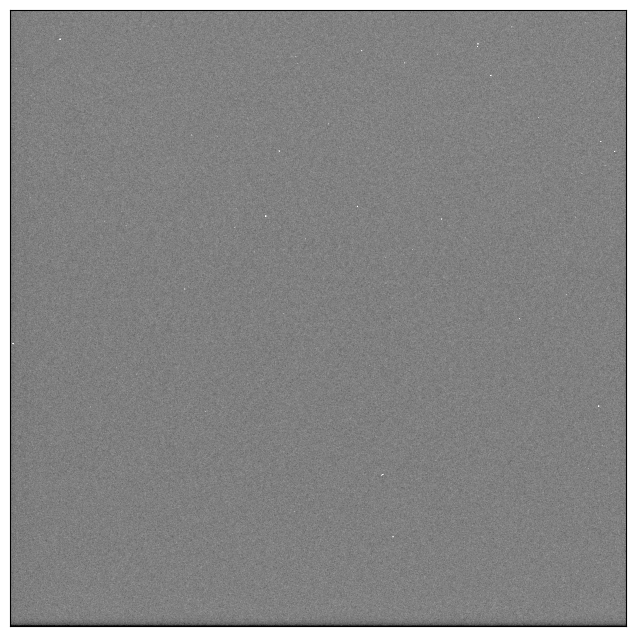

In [7]:
#Create the Master Bias Image
images = []
for path in biaspaths:
    # load the image data
    rawimage = fits.getdata(path).astype(np.float64)

    # remove the overscan
    image = remove_overscan(rawimage)

    # add to the list
    images.append(image)
  
# convert images list into a 3D array
datacube = np.stack(images)
print(datacube.shape)

#Create Master Bias Image
bias = np.mean(datacube, axis=0)

print(bias.shape)

#Test Bias Image
show_image(bias)
print(np.mean(bias))

(2048, 2048) (2048, 2048)


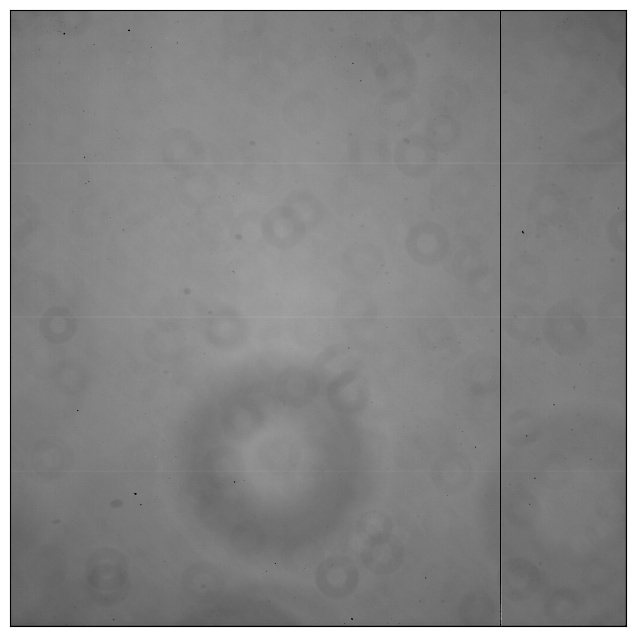

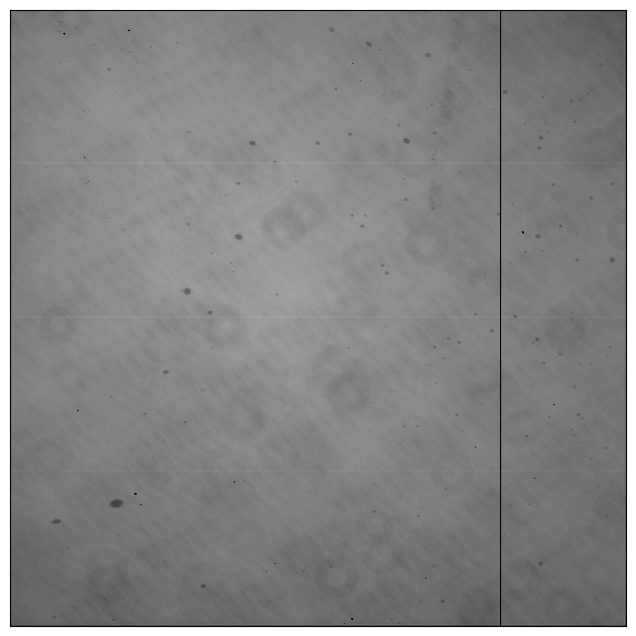

In [8]:
#Create Master Flat Field Images
def create_master_flat(fname, bias):
    
    data1 = fits.getdata(fname)
    data = remove_overscan(data1)
    
    flat_corrected = data - bias
    
    med_val = np.median(flat_corrected)
    
    master_flat = flat_corrected / med_val

    return master_flat

#List to store processed master flat images
master_b = []
master_v = []

for path in flat_vpaths:    
    # Apply create_master_flat individually for each image
    master_flat_imagev = create_master_flat(path, bias)
    master_v.append(master_flat_imagev)

processed_master_v = np.stack(master_v)
processed_v = np.median(processed_master_v, axis=0)
    
for path in flat_bpaths:    
    master_flat_imageb = create_master_flat(path, bias)
    master_b.append(master_flat_imageb) 
    
# Convert processed master flats list into a 3D array
processed_master_b = np.stack(master_b)
processed_b = np.median(processed_master_b, axis=0)

print(processed_v.shape, processed_b.shape)
show_image(processed_v)
show_image(processed_b)

Processed image min/max: -7088.961381590745 66218.86817964895 45.95777633428321
Processed image min/max: -5372.590603166147 66440.47744373075 181.9927007226607
Processed image min/max: -6227.169216651802 17497.37457064122 11.65654809754057
Processed image min/max: -4719.193277319245 65697.61525311254 47.24809884621528
Processed image min/max: -4719.193277319245 65697.61525311254 47.24809884621528
Processed image min/max: -5315.867355503823 35581.75124839856 11.936077556866445


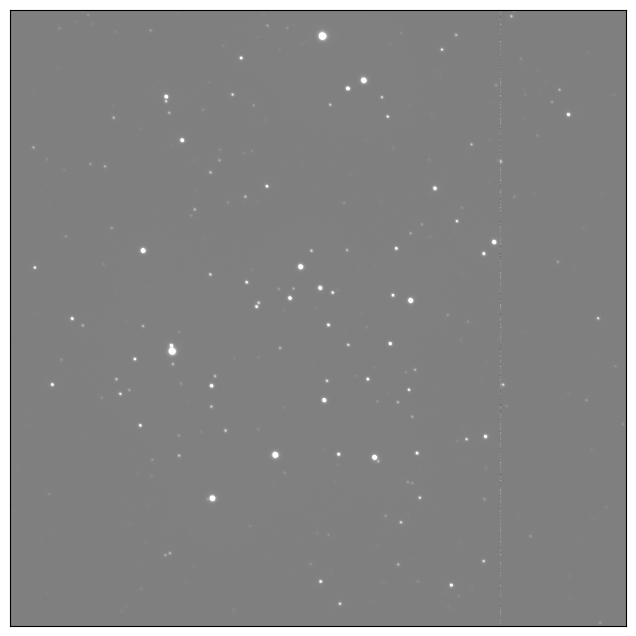

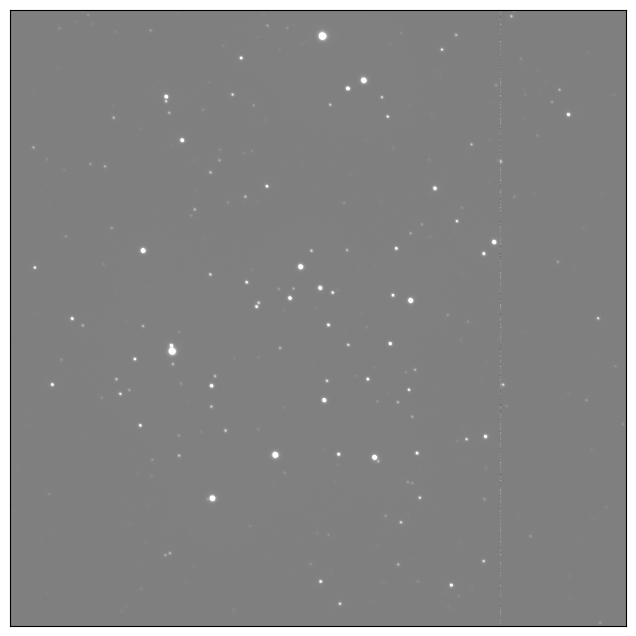

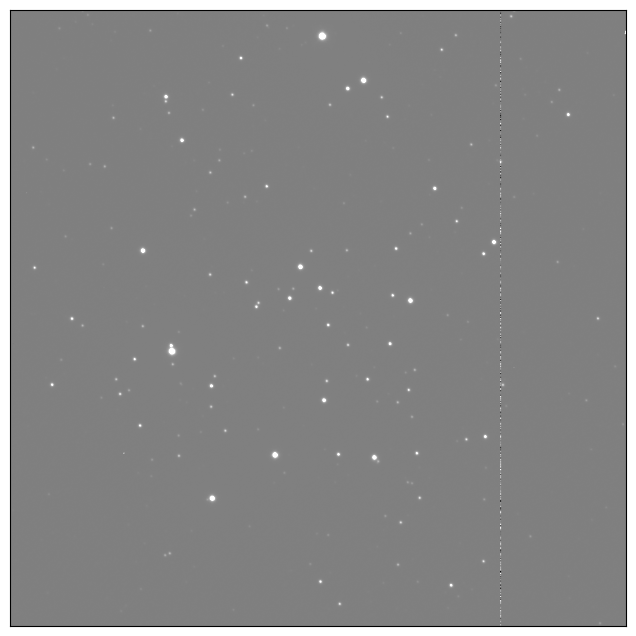

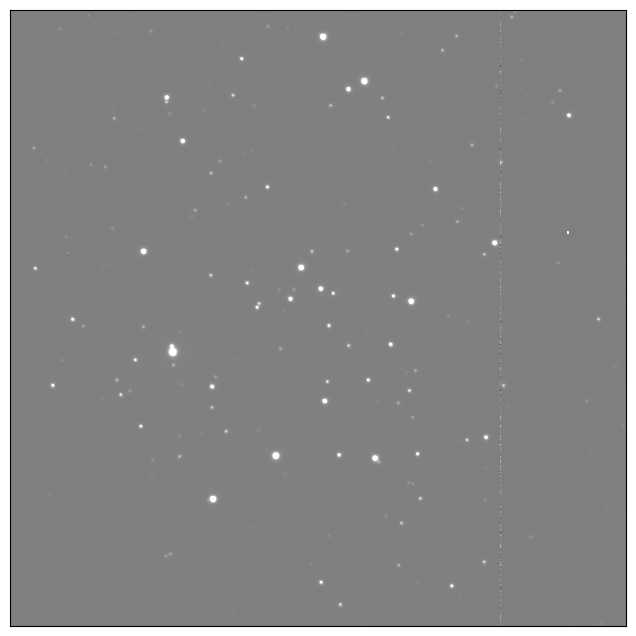

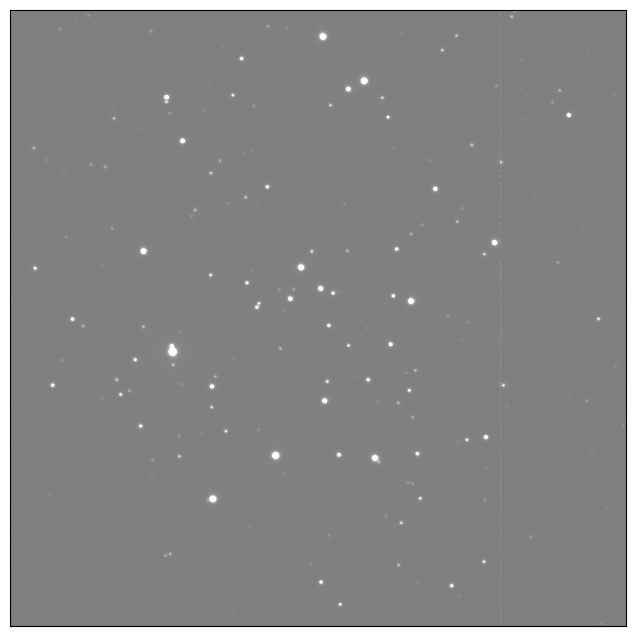

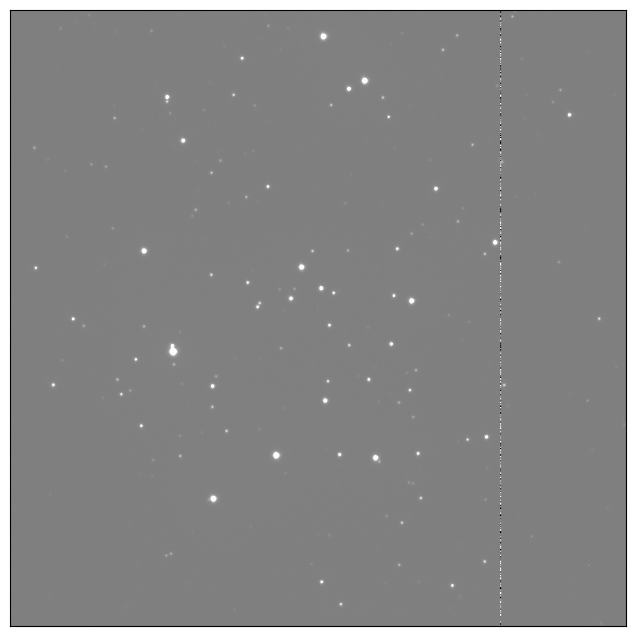

In [9]:
#Process Target Images

def get_proc_image(bias, flat, path):
    """
    Returns a fully processed (de-bias and flat-field corrected) image.

    bias: 2D numpy array (master bias)
    flat: 2D numpy array (master flat)
    path: str (FITS image path to be processed)
    """
    # Load the data
    rawimage = fits.getdata(path).astype(np.float64)

    # Remove overscan
    data = remove_overscan(rawimage)

    # Process: subtract bias, then divide by flat
    procim = (data - bias) / flat
    print("Processed image min/max:", np.min(procim), np.max(procim), np.median(procim))

    return procim
#Figure out how to parse this function through an array for the paths argument
proc_b_20 = get_proc_image(bias, processed_b, b_20_path)
proc_b_80 = get_proc_image(bias, processed_b, b_80_path)
proc_b_05 = get_proc_image(bias, processed_b, b_05_path)

proc_v_20 = get_proc_image(bias, processed_v, v_20_path)
proc_v_80 = get_proc_image(bias, processed_v, v_20_path)
proc_v_05 = get_proc_image(bias, processed_v, v_05_path)


img_v20 = show_image(proc_v_20)
img_v80 = show_image(proc_v_80)
img_v05 = show_image(proc_v_05)

img_b20 = show_image(proc_b_20)
img_b80 = show_image(proc_b_80)
img_b05 = show_image(proc_b_05)
#Need to process all 6 images seperately, each are its own exposure times.

### Step 2
Querey the Gaia archive to locate the source ID, R.A. and Dec. of known stars in your chosen field. Also record the distance (parallax) and proper motion values and uncertainties for each star for later use. Retrieve only stars with $G_{BP}$ < 19 mag and parallaxes that are at least 5 times greater than the uncertainty. 

In [10]:
# query Gaia archive
# (store the resulting table in a variable called `gaia`)

# Define your target field center and search radius
center = SkyCoord.from_name('NGC2323', frame='icrs') 
radius = .15* u.deg  # search radius

# Build the ADQL query
query = f"""
SELECT 
  source_id, ra, dec,
  parallax, parallax_error,
  pmra, pmra_error, pmdec, pmdec_error,
  phot_bp_mean_mag
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', {center.ra.degree}, {center.dec.degree}, {radius.to(u.degree).value})
)
AND phot_bp_mean_mag < 19
AND parallax / parallax_error > 5
"""

# Execute the query
job = Gaia.launch_job_async(query)
gaia = job.get_results()

# Test the first few rows
print(gaia[:5])
len(gaia)

INFO: Query finished. [astroquery.utils.tap.core]
     SOURCE_ID              ra         ... pmdec_error phot_bp_mean_mag
                           deg         ...   mas / yr        mag       
------------------- ------------------ ... ----------- ----------------
3052315334646601088 105.53967033121543 ... 0.027900206        14.817469
3052315369006349696 105.54510489068075 ...  0.11038835         18.55327
3052315369006818048 105.54276528306721 ... 0.015711408        12.329924
3052315373310795520 105.54810610117077 ... 0.027008025        15.534345
3052315373310797440 105.54464580696273 ... 0.072258465        17.517572


824

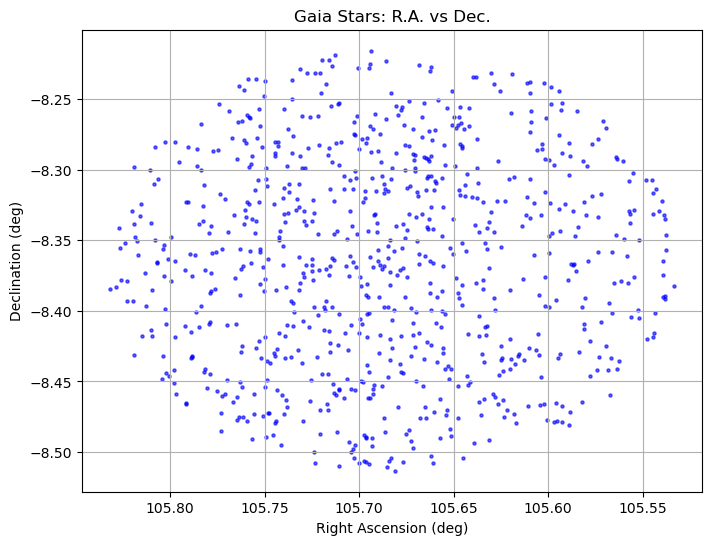

In [11]:
# plot the R.A. and Dec. of the Gaia stars
plt.figure(figsize=(8, 6))
plt.scatter(gaia['ra'], gaia['dec'], s=5, c='blue', alpha=0.6)
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Gaia Stars: R.A. vs Dec.')
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

**Note:** You will find it convenient to store all data on each star together in a single python object. The following `dtype` list includes the values you will (eventually) want to record for each star. The comments tell you if you should get the information from your Gaia query above or later from APASS or your own reduction of the MLO image data (see the following steps for more on this).

In [12]:
dtype = []
dtype.append( ('id', 'U24') )  # unique identifier from Gaia for a given star (Gaia)
dtype.append( ('ra', float) )  # Right Ascention (Gaia)
dtype.append( ('dec', float) ) # Declination (Gaia)
dtype.append( ('distance', float) ) # distance to a star in parsec (from Gaia parallax)
dtype.append( ('edistance', float) ) # distance uncertainty parsec (from Gaia parallax)
dtype.append( ('pmra', float) ) # proper motion in R.A. (Gaia)
dtype.append( ('pmdec', float) ) # proper motion in Dec. (Gaia)
dtype.append( ('Bmag_cat', float) ) # cataloged B-band magnitude (APASS)
dtype.append( ('Vmag_cat', float) ) # cataloged V-band magnitude (APASS)
dtype.append( ('Bmag', float) ) # observed B-band magnitude (MLO data)
dtype.append( ('eBmag', float) ) # uncertainty in observed B-band magnitude (MLO data)
dtype.append( ('Vmag', float) ) # observed V-band magnitude (MLO data)
dtype.append( ('eVmag', float) ) # uncertainty in observed V-band magnitude (MLO data)

In [13]:
# Initialize a `data` object to hold all the data for each star 
# and begin populating the fields with the data from Gaia
# (remaining fields will be populated in later steps)
data = np.zeros(len(gaia), dtype=dtype)
data['id'] = gaia['SOURCE_ID']
data['ra'] = gaia['ra']
data['dec'] = gaia['dec']
data['distance'] = 1000 / gaia['parallax']
data['edistance'] = 1000 * gaia['parallax_error'] / gaia['parallax']**2
data['pmra'] = gaia['pmra']
data['pmdec'] = gaia['pmdec']

# start witn NaN values for magnitudes to be determined later
data['Bmag_cat'] = np.nan
data['Vmag_cat'] = np.nan
data['Bmag'] = np.nan
data['eBmag'] = np.nan
data['Vmag'] = np.nan
data['eVmag'] = np.nan


### Step 3
Record the B and/or V band magnitudes along with the R.A. and Dec. of stars in the field that appear in the [APASS catalog](https://www.aavso.org/apass) (see VizieR catalog [II/336/apass9](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=II/336/apass9)). These will be used to determine zeropoints for the MLO 1.0m images.

In [14]:
# first query VizieR to locate APASS stars within 
# 8 arcminutes of your cluster's coordinates

# Define your cluster coordinates (update to your cluster)
cluster_coord = SkyCoord.from_name('NGC2323', frame='icrs') 

# Search radius: 8 arcminutes
radius = 8 * u.arcmin

# Perform the query on the APASS catalog (II/336/apass9)
apass_result = Vizier.query_region(cluster_coord, radius=radius, catalog='II/336/apass9')

# Extract the table from the result
apass = apass_result[0]  # the result is a list of tables

# Display the first few rows
print(apass[:5])

 RAJ2000    DEJ2000   e_RAJ2000 e_DEJ2000 ... r_mag  e_r_mag i_mag  e_i_mag
   deg        deg       arcsec    arcsec  ...  mag     mag    mag     mag  
---------- ---------- --------- --------- ... ------ ------- ------ -------
105.712161  -8.486506     0.812     1.059 ... 15.489   0.109 15.275   0.083
105.720745  -8.487076     0.519     0.239 ... 14.477   0.036 14.211   0.014
105.740099  -8.472669     0.944     0.795 ... 15.293   0.053 14.886   0.017
105.739101  -8.462239     0.187     0.892 ... 13.383   0.019 13.485   0.568
105.748683  -8.472657     0.244     0.290 ... 11.462   0.022 11.520   0.020


In [15]:
# match the APASS sources to the Gaia sources by their coordinates

# Create SkyCoord objects for both catalogs
# Create SkyCoord objects for both APASS and Gaia
coords_apass = SkyCoord(ra=apass['RAJ2000'], dec=apass['DEJ2000'], unit='deg')
coords_gaia = SkyCoord(ra=gaia['ra'], dec=gaia['dec'], unit='deg')

# Match each APASS star to the nearest Gaia star
idx, d2d, _ = coords_apass.match_to_catalog_sky(coords_gaia)

# Set a matching threshold, e.g., 1 arcsecond
max_sep = 1.0 * u.arcsec
match_mask = d2d < max_sep

# Keep only matches within the threshold
matched_apass = apass[match_mask]
matched_gaia = gaia[idx[match_mask]]

print(f"Matched {len(matched_apass)} APASS stars to Gaia sources.")

Matched 26 APASS stars to Gaia sources.


In [16]:
# record the APASS magnitudes in the `data` object for later use

# Build SkyCoord for `data` and `matched_gaia` to align indices
coords_data = SkyCoord(ra=data['ra'], dec=data['dec'], unit='deg')
coords_matched = SkyCoord(ra=matched_gaia['ra'], dec=matched_gaia['dec'], unit='deg')

# Match Gaia entries in `data` to those in matched_gaia (safe because we know these are from Gaia)
idx_data, d2d, _ = coords_data.match_to_catalog_sky(coords_matched)

# Apply a small separation threshold to be sure
sep_mask = d2d < 1.0 * u.arcsec

# Transfer APASS magnitudes and uncertainties into the `data` array
data['Bmag_cat'][sep_mask] = matched_apass['Bmag'][idx_data[sep_mask]]
data['Vmag_cat'][sep_mask] = matched_apass['Vmag'][idx_data[sep_mask]]

### Step 4
Measure the B and V band brightness on the MLO 1.0m data for all stars cataloged by Gaia in the field and 
fill in the appropriate fields in the `data` array.

Note the image headers include WCS information, and you can use this to transform the R.A. and Dec. of Gaia objects to x, y positions on each image. Also note the headers contain an added `FWHM` keyword.

For each filter (B and V) there are 5-second, 20-second, and 80-second exposures. The shorter exposure times are best suited to recording the magnitudes of bright objects while the longer exposure times are best for measuring faint magnitudes. Start with the shortest exposure time in each band and attempt to measure the flux in a 1-FWHM radius aperture centered at the x, y position corresponding to the R.A. and Dec. of each Gaia source. Check to see if any of the pixels in the aperture are brighter than the linearity limit of our detector (about 50000 counts). If any pixel within the aperture is above this limit, **do not** record its magnitude. Repeat with the 20 and 80-second exposures to replace measurements with the deeper data provided the star is below the linearity limit. You need to do this for both the B-band and the V-band images (6 images total).

To convert your measured counts into observed magnitudes you will need to calculate a zeropoint using the magnitudes from the APASS catalog.

**Important:** You should add 0.01 mag uncertainty in quadrature to each of your measured magnitudes to account for a 1% uncertainty in flat-fielding.

In [22]:
# show your work

def get_counts(image, xs, ys, radius):
    """
    Return the total (local background subtracted) counts and uncertainty in a circular aperture 
    
    `image` -- the 2D numpy array holding the counts recorded at each pixel
    `xs` -- an array of x-positions for the aperture centures
    `ys` -- an array of y-positions for the aperture centures
    `radius` -- radius (float) of the circular apertures in pixels
    """
    
    # make sure xs and ys are numpy arrays
    xs = np.atleast_1d(xs)
    ys = np.atleast_1d(ys)

    # size of the image
    ny, nx = image.shape
    
    # x, y coordinates for each pixel in the image
    imy, imx = np.indices(image.shape)
    
    # Start by creating an empty list to hold the measurements.
    # The loop below will add one row to this list at a time.
    # Each row will be a numpy structured array with columns named "counts" and "ecounts".
    # At the end, `measurements` will be converted from a list object to a numpy array.
    measurements = []
    dtype = [('counts', float), ('ecounts', float)]

    # determine the local background level for each position
    for x, y in zip(xs, ys):
        # make sure the aperture is fully contained on the image
        if (x < radius) | (y < radius) | (x > (nx-radius)) | (y > (ny-radius)):
            measurements.append( np.array( (np.nan, np.nan), dtype=dtype) )
            continue
        
        # define a circular aperture at this x, y
        aperture = CircularAperture((x,y), r=radius)

        # measure the counts in this aperture
        phot_table = aperture.do_photometry(image)
    
        # determine the distance from this x,y to each pixel in the image
        # hint: use imx and imy defined above
        dists = np.sqrt((imx - x)**2 + (imy - y)**2)

        # define a truth array, wbg, that is True only for image pixels 
        # from 4 * radius to 6 * radius from the target. This annulus
        # will be used to define the local background.
        wbg = (dists > 4*radius) & (dists < 6*radius)
        
        # find the local background values in the annulus
        bg_sample = image[wbg]
        
        # subtract the background contribution from the aperture sum (be careful!)
        bg_counts = bg_sample.mean()*aperture.area
        counts = phot_table[0][0] - bg_counts

        # get the uncertainty
        obj_var = np.abs(counts)
        bg_var = aperture.area * bg_sample.var()
        avbg_var = bg_sample.var() / bg_sample.size * aperture.area**2
        ecounts = np.sqrt( obj_var + bg_var +  avbg_var)

        # add this measurement
        measurements.append( np.array( (counts, ecounts), dtype=dtype) )
    measurements = np.array(measurements)
        
    return measurements['counts'], measurements['ecounts']


radius = 3.0  # aperture radius in pixels
limit = 50000  # saturation threshold
flat_uncertainty = 0.01

# List of processed images (arrays) and corresponding headers
b_images = [proc_b_05, proc_b_20, proc_b_80]
v_images = [proc_v_05, proc_v_20, proc_v_80]
b_headers = [fits.getheader(b_05_path), fits.getheader(b_20_path), fits.getheader(b_80_path)]
v_headers = [fits.getheader(v_05_path), fits.getheader(v_20_path), fits.getheader(v_80_path)]

# Process each filter
for filt, images, headers, mag_cat_key, mag_key, emag_key in [
    ('B', b_images, b_headers, 'Bmag_cat', 'Bmag', 'eBmag'),
    ('V', v_images, v_headers, 'Vmag_cat', 'Vmag', 'eVmag')
]:
    for i in range(len(data)):
        coord = SkyCoord(ra=data['ra'][i]*u.deg, dec=data['dec'][i]*u.deg, frame='icrs')
        success = False

        for img, hdr in zip(images, headers):
            if 'MJD-OBS' not in hdr and 'DATE-OBS' in hdr:
                hdr['MJD-OBS'] = Time(hdr['DATE-OBS']).mjd

            wcs = WCS(hdr)
            x, y = wcs.world_to_pixel(coord)

            counts, errors = get_counts(img, [x], [y], radius)
            c = float(counts[0])
            e = float(errors[0])

            if not np.isfinite(c) or c <= 0 or c > limit:
                continue

            # Calculate zeropoint and magnitude
            zp = data[mag_cat_key][i] + 2.5 * np.log10(c)
            mag = zp - 2.5 * np.log10(c)
            mag_err = np.sqrt((2.5 / np.log(10) * e / c)**2 + flat_uncertainty**2)

            data[mag_key][i] = mag
            data[emag_key][i] = mag_err
            success = True
            break

        if not success:
            data[mag_key][i] = np.nan
            data[emag_key][i] = np.nan

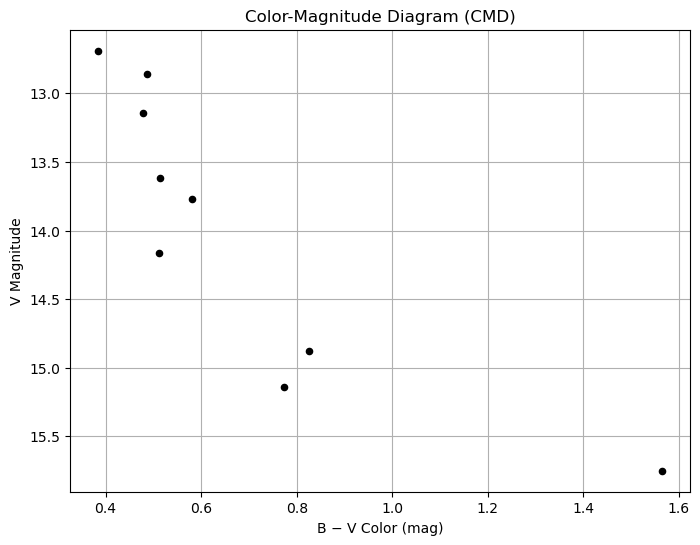

In [23]:
# once you have your photometry complete, plot the V-band 
# magnitudes vs. B-V color for all stars with magnitude
# measurements in both B and V-bands
# Compute color index and V magnitude

valid = np.isfinite(data['Bmag']) & np.isfinite(data['Vmag'])
B_V = data['Bmag'][valid] - data['Vmag'][valid]
Vmag = data['Vmag'][valid]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(B_V, Vmag, s=20, c='black')
plt.xlabel("B − V Color (mag)")
plt.ylabel("V Magnitude")
plt.title("Color-Magnitude Diagram (CMD)")
plt.gca().invert_yaxis()  # Bright stars at top
plt.grid(True)
plt.show()

### Save your `data` to a file for later use

In [24]:
import pickle
datafile = 'my_data.pkl'
print('saving data to', datafile)
pickle.dump(data, open(datafile, 'wb'))

saving data to my_data.pkl


### Remember to submit this notebook by the first deadline, then continue on to the Part 2 notebook.